# **Проект NLP**
# Cтудента первого курса ФКН ПМИ Палысаева Вадима
В данном проекте по введению в NLP, я решил рассмотреть задачу классификации сообщений на спам/неспам (или же по-другому детектор спама). И написать собственную нейро-сеть на основе существующих алгоритмов используемых в данной тематике.
Целями данного задания были:
1. Произвести предворительный анализ выбранного датасета
2.   Научиться первичной обработке входного текста
3.   Научиться приводить тексты к векторам
4.   Написать и обучить нейро-сеть на основе известных алгоритмов для распознавания sms-спама
5. Проанализировать и оценить качество написанной нейронной сети с помощью accuracy и ROC-AUC метрики

Для написания проекта мне пришлось дополнительно изучить работу и применение таких библиотек, как: pandas (для чтения датасета) , nltk (для предобработки данных), seabor и sklearn (для векторизации текстов), а также изучить способы обработки вводимых данных и приведения их к понятной для алгоритмов обучения форме.


Также мне понадобилось ознакомиться  с работой мешка слов (bag-of-words) и алгоритма машинного обучения Наивный Байесовский Классификатор и алгоритма Логистической регрессии (logistic regression), которые я использовал для написания данной нейросети.

## Сперва импортируем необходимые для работы библиотеки:

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

## Далее я решил провести краткий анализ выбранного для работы датасета, чтобы лучше понять с какими данными нам придется работать:

In [6]:
# Читаю файл с датасетом с помощью pandas и вывожу таблицу читаемых данных:
sms = pd.read_csv("/spam-ham_data.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar then Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Теперь выведем более подробную информацию о датасете за счет describe
sms.describe()

,label,message
count,5572,5572
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
# Рассмотрим отдельно информацию о сообщениях спам и неспам
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Мы имеем 4825 сообщений неспама и 747 сообщений спама

In [9]:
# Теперь введем обозначение ham == 0 и spam == 1, а также длинну для каждого сообщения:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar then Joking wif u oni,0,30
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0, 0.5, 'Количество сообщений')

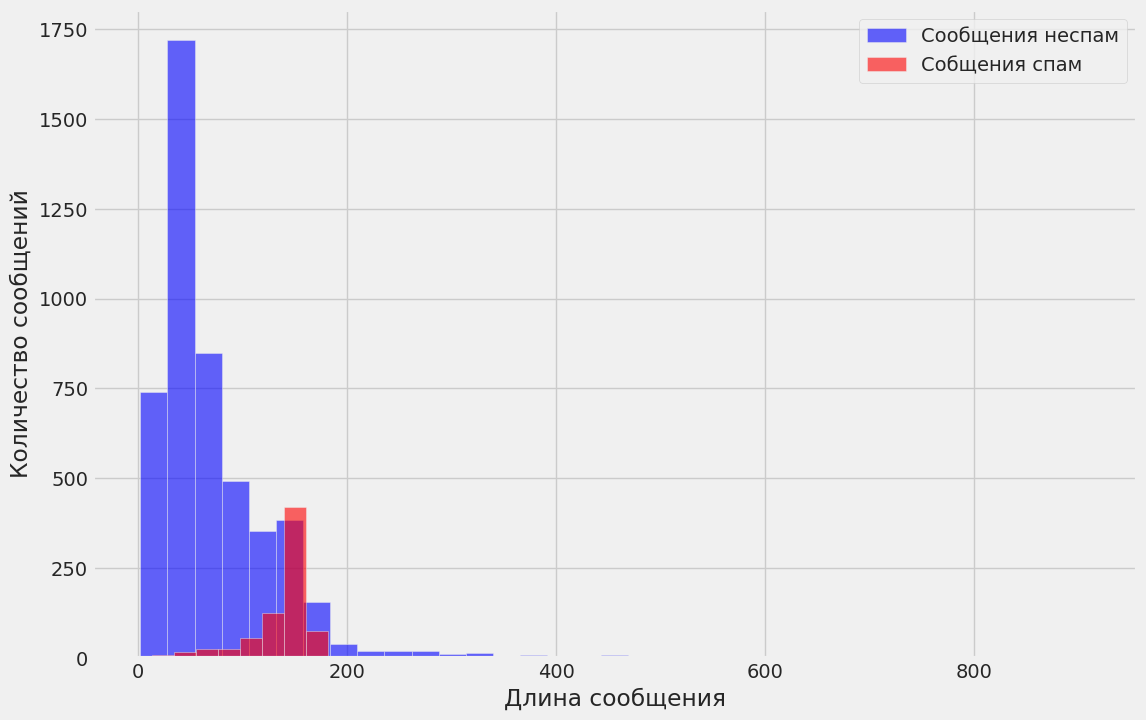

In [10]:
# Построим график для наглядного понимания и сравнения спам/неспам сообщений
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue',
                                       label='Сообщения неспам', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red',
                                       label='Собщения спам', alpha=0.6)
plt.legend()
plt.xlabel("Длина сообщения")
plt.ylabel("Количество сообщений")

Как мы видим для спам сообщений характерна большая длина

In [11]:
# Теперь более подробно рассмотрим информацию о неспам-сообщениях:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.589016
std,0.0,58.337050
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,93.000000
max,0.0,910.000000


In [12]:
# И также информацию о спам-сообщениях:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,139.119143
std,0.0,28.976564
min,1.0,13.000000
25%,1.0,133.000000
50%,1.0,149.000000
75%,1.0,158.000000
max,1.0,224.000000


## Произведем предобработку нашего датасета для того, чтобы далее его можно было использовать для обучения модели:

Для того, чтобы использовать наши данные в обучении модели нам необходимо привести их к векторному виду, однако для этого нам необходимо провести их предобработку: удаление знаков препинания, частых слов (имеющих малое значение для обучения) и стоп-слов

In [13]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [14]:
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar then Joking wif u oni,0,30
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [15]:
# Токенизируем текст и выведем обработанные данные:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
sms['clean_msg'] = sms.message.apply(text_process)

In [17]:
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar then Joking wif u oni,0,30,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [18]:
type(stopwords.words('english'))

list

Теперь когда текст обработан и токенизирован, выведем слова, которые чаще всего встречаются в неспам-сообщениях:

In [19]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)

print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 273), ('go', 250), ('ill', 237), ('got', 232), ('know', 232), ('like', 231), ('call', 230), ('come', 226), ('good', 224), ('love', 190), ('time', 189), ('day', 188), ('going', 167), ('want', 164), ('one', 163), ('home', 160), ('lor', 160), ('need', 157), ('sorry', 153), ('still', 147), ('see', 137), ('n', 135), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 127), ('today', 125), ('send', 123), ('tell', 121), ('cant', 119), ('ì', 117), ('hi', 117), ('take', 112), ('oh', 112), ('much', 112), ('night', 108), ('happy', 106), ('hey', 106), ('great', 100), ('way', 100), ('hope', 100), ('pls', 98), ('work', 97), ('wat', 95), ('thats', 95), ('give', 94)]


А теперь выведем слова, которые чаще всего встречаются в спам-сообщениях:

In [20]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)

print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('stop', 115), ('claim', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 68), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('16', 51), ('guaranteed', 50), ('customer', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('box', 32), ('holiday', 32), ('landline', 32), ('po', 31), ('shows', 31), ('å£2000', 31), ('go', 31), ('number', 30), ('apply', 29), ('code', 29)]


## Векторизация

Мы обработали наши данные и получили список токенов, теперь нам необходимо преобразовать каждое из этих сообщений в вектор, с которым могут работать модели алгоритмов. Для векторизации мы воспользуемся мешком слов (bag-of-words):
1. Сперва необходимо посчитать как часто слово встречается в каждом сообщении
2. Обозначим вес для слов обратно пропорционально частоте встречаемости в сообщениях
3. Ноормализуем векторы до единичной длины.

Каждый вектор будет иметь столько измерений, сколько уникальных слов в корпусе sms. Сначала мы будем использовать CountVectorizer, эта модель преобразует коллекцию текстовых документов в матрицу количества токенов.

In [21]:
# определим x и y для использования CountVectorizer
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [22]:
# Разделим x и y на обучающие и тестовые наборы:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [23]:
# Векторизуем обучающую выборку
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [24]:
X_train_dtm = vect.transform(X_train)
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<4179x8076 sparse matrix of type '<class 'numpy.int64'>'
	with 35009 stored elements in Compressed Sparse Row format>

In [25]:
# преобразуем тестовые данные в матрицу терминов документа
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x8076 sparse matrix of type '<class 'numpy.int64'>'
	with 10023 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x8076 sparse matrix of type '<class 'numpy.float64'>'
	with 35009 stored elements in Compressed Sparse Row format>

## Построение модели Наивного Байесовского Классификатора (MultinomialNB)

В качестве модели я решил использовать алгоритм Наивного Байесовского Классификатора. Данный алгоритм предназначен для классификации текста по дискретным признакам

In [27]:
# Импортируем и создадим экземпляр Наивной Байесовской модели с помощью библиотеки sklearn
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [28]:
# Обучим модель
%time nb.fit(X_train_dtm, y_train)

CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 3.83 ms


MultinomialNB()

In [29]:
# составим прогноз для X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [30]:
# рассчитаем точность обученной на тестовой выборке модели
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9842067480258435

Точность нашей нейро-сети более 98 процентов

In [31]:
# выведем матрицу наших результатов проверки точности
metrics.confusion_matrix(y_test, y_pred_class)

array([[1205,    8],
       [  14,  166]])

In [32]:
X_test.shape

(1393,)

In [33]:
# Выведем информацию о ложных классификациях, когда неспам помечается как спам:
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [34]:
# Выведем информацию о ложных классификациях, когда спам помечается как неспам:
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [36]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.12908436e-02, 3.96941143e-04, 1.03181825e-03, ...,
       1.33203727e-02, 1.00059546e-04, 6.00097623e-06])

Как мы видим данная модель плохо откалибрована (справка: что значит модель хорошо или плохо откалибрована? Это значит что модель с высокой или низкой уверенностью предсказывает правильный результат, данная метрика необходима для пониманию того насколько наша модель будет точно производить классификацию на реальных данных

In [37]:
# высчитаем ROC-AUC (площадь под кривой ошибок)
metrics.roc_auc_score(y_test, y_pred_prob)

0.9773701566364386

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', MultinomialNB())])

In [39]:
y_pred = pipe.predict(X_test)

In [40]:
metrics.accuracy_score(y_test, y_pred)

0.9662598707824839

In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[1213,    0],
       [  47,  133]])

Как мы видим точность нашей модели построенной на алгоритме Наивного Байесовского Классификатора составляет более 98 процентов, однако при этом данная модель явно не откалиброванна, теперь давайте построим другую модель и сравним две получившиеся модели:

## Построение модели Логистической регрессии (logistic regression)

Логистическая регрессия (logistic regression) также имеет назавние логарифмический линейный классификатор. В этой модели вероятности, описывающие возможные исходы, моделируются с использованием логистической функции.

In [49]:
# импортируем модель логистической регрессии
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')

In [50]:
# обучим ее на тренировочной выборке
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 25.5 ms


LogisticRegression(solver='liblinear')

In [51]:
# создадим класс прогнозов для X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [52]:
# вычислим прогнозируемую вероятность
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01694011, 0.01470674, 0.081146  , ..., 0.02175685, 0.00518289,
       0.00680777])

Как видим данная модель хорошо откалибрована и разительно отличается от предыдущей в этом плане, теперь надо проверить ее точность:

In [53]:
# выведем точность получившейся модели
metrics.accuracy_score(y_test, y_pred_class)

0.9842067480258435

Как видим точность этой модели также выше 98 процентов и при том она хорошо откалибрована (с большей уверенностью предсказывает верный результат) а значит на реальных данных она будет более корректно предсказывать спам чем предыдущая

In [54]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[1213,    0],
       [  22,  158]])

In [55]:
# и высчитаем ROC_AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.983292113217917

## Как можно оптимизировать модель за счет улучшения классификатора дополнительными параметрами?

In [56]:
# выведем параметры по умолчанию
vect

CountVectorizer()

### Теперь рассмотрим методы улучшения векторизатора:

Первый парметр это стоп-слова, если данные представленны на английском языке, то используем встроенный список стоп-слов

In [ ]:
vect = CountVectorizer(stop_words='english')

Второй параметр, который мы можем использовать это ngram_range, то есть создание границ диапазона значений для различных n-грамм

In [ ]:
vect = CountVectorizer(ngram_range=(1, 2))

Использование max_df и min_dt, то есть при построении словаря будут игнорироваться слова из текстов, частота которых строго выше или строго меньше порогового значения

In [ ]:
vect = CountVectorizer(max_df=0.5)

In [ ]:
vect = CountVectorizer(min_df=2)

## Вывод:
В ходе данной работы я рассмотрел задачу классификации спама, я произвел предварительный анализ датасета, научился предобрабатывать и токенизировать данные. Далее я правратил получившиеся данные в векторы (векторизировал) и изучил параметры, которые могут помочь в улучшении векторизации выборки.
На следующем шаге я изучил и построил две модели классификации (Наивный Байесовский Классификатор (MultinomialNB) и алгоритм Логистической регрессии (logistic regression)), которые используются для решения задачи классификации спама, сравнил их и пришел к следущим выводам:

Обе модели показывают высокую точность классификации спама (более 98 процентов), однако с помощью функции predict_proba я выяснил, что модель Наивного Байесовского Классификатора с меньшей уверенностью предсказывает верный результат (то есть она не откалибрована), в то время как Логистическая регрессия показала хороший уровень колибровки, что означает, что на реальных данных алгоритм Логистической регрессии будет предсказывать верный вердикт точнее чем первая модель.

В конце работы хочу поблагодарить Бориса Васильевича Галицкого за прочитанный курс по введению в НЛП, этот курс во многом помог мне понять как в общем устроена система создания нейро-сетей работающих с естественным языком, как необходимо обрабатывать данные для того, чтобы алгоритмы могли на них обучаться, как строить саму модель нейро-сети, анализировать ее точность и прогнозировать качество ее работы на реальных данных.